In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
import os
dataset_path = "/content/drive/MyDrive/casia/CASIA2"
authentic_path = os.path.join(dataset_path, "Au")
tampered_path= os.path.join(dataset_path, "Tp")
print(len(os.listdir(authentic_path)))
print(len(os.listdir(tampered_path)))

7609
5180


In [ ]:
auth = os.listdir(authentic_path)


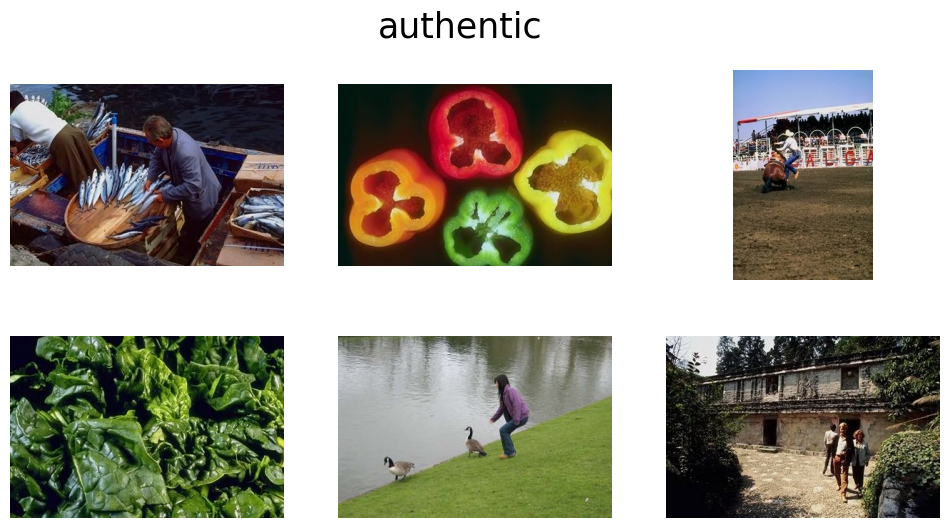

In [ ]:
num_images_to_display = 6
plt.figure(figsize=(12, 6))

for i in range(num_images_to_display):
    img_path = os.path.join(authentic_path,auth[i])
    img = Image.open(img_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("authentic",fontsize=25)
    plt.axis('off')

plt.show()

In [ ]:
tampered = os.listdir(tampered_path)

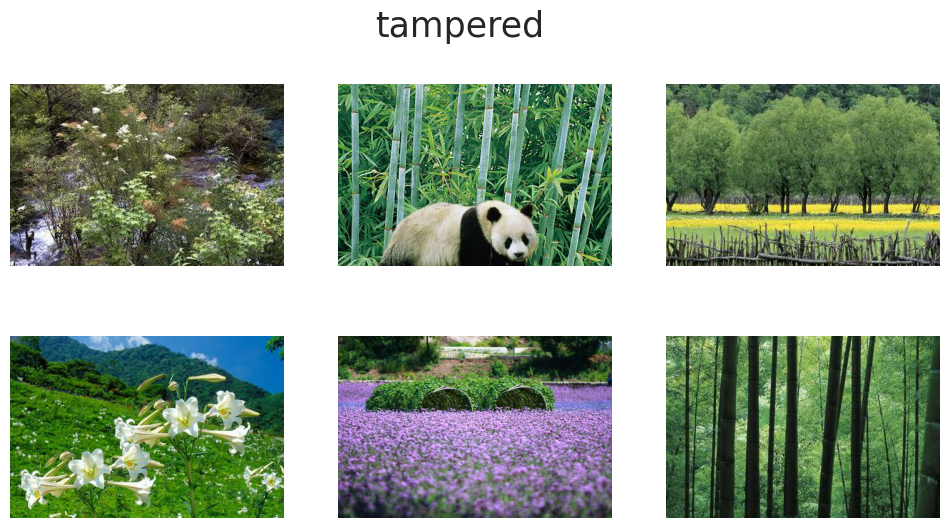

In [ ]:
num_images_to_display = 6
plt.figure(figsize=(12, 6))

for i in range(num_images_to_display):
    img_path2 = os.path.join(tampered_path,tampered[i])
    img = Image.open(img_path2)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.suptitle("tampered",fontsize=25)
    plt.axis('off')

plt.show()

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')  #image compression
    image.save(temp_filename, 'JPEG', quality = quality) # fixing the quality parameter to further compress the file size
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image) #Calculating the absolute numerical difference between two images

    extrema = ela_image.getextrema() #Getting the extrema (minimum and maximum pixel values) of the ELA image
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

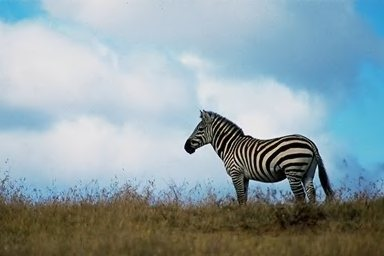

In [ ]:
authentic_image_path = r'/content/drive/MyDrive/casia/CASIA1/Au/Au_ani_0001.jpg'
Image.open(authentic_image_path)

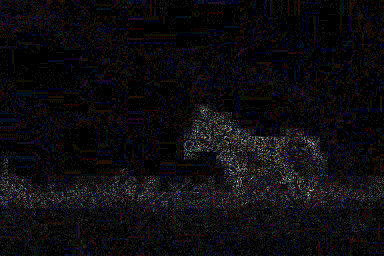

In [ ]:
convert_to_ela_image(authentic_image_path, 90)

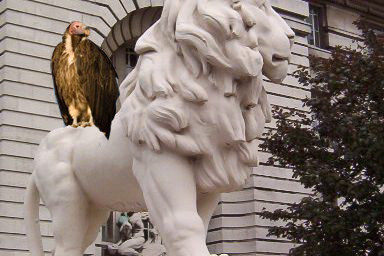

In [ ]:
tampered_image_path=r'/content/drive/MyDrive/casia/CASIA2/Tp/Tp_D_CNN_S_N_art00001_ani00074_10442.tif'
Image.open(tampered_image_path)

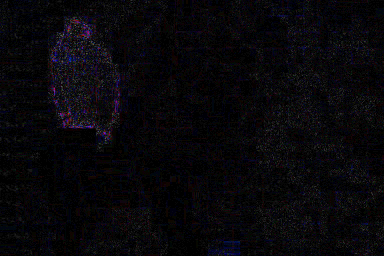

In [ ]:
convert_to_ela_image(tampered_image_path, 90)

In [ ]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0
X = []
Y = []

In [ ]:
import random
path = '/content/drive/MyDrive/casia/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:1500]
Y = Y[:1500]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
1500 1500


In [ ]:
path = '/content/drive/MyDrive/casia/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
      if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
3589 3589


In [ ]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

#Train Test split with 80:20 ratio

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2871 2871
718 718


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have already loaded and preprocessed your dataset (X_train, Y_train, X_val, Y_val)

# Load VGG16 model without top layers (include_top=False)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

# Create a new model and add VGG16 layers followed by custom dense layers
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
epochs = 20
batch_size = 32

# Assuming you have X_train, Y_train, X_val, Y_val

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(patience=2)])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 2097922 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/20
90/90 [==============================] - 7s 64ms/step - loss: 0.5188 - accuracy: 0.7795 - val_loss: 0.4175 - val_accuracy: 0.8468

In [ ]:
# Evaluate the model on the validation set
evaluation = model.evaluate(X_val, Y_val)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])


23/23 [==============================] - 1s 46ms/step - loss: 0.3142 - accuracy: 0.8816
Validation Loss: 0.31418129801750183
Validation Accuracy: 0.8816155791282654


In [ ]:
model.save("model-vgg16.h5")

In [ ]:
Y_val.shape

(718, 2)

In [ ]:

# Predict on the validation set
y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_val, axis=1)

labels = [True, False]

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes , labels = labels )


23/23 [==============================] - 1s 42ms/step


In [ ]:
type(confusion_mtx)

numpy.ndarray

In [ ]:
confusion_mtx

array([[226,  71],
       [ 14, 407]])

In [ ]:
# Calculate evaluation metrics
TP = confusion_mtx[1, 1]
TN = confusion_mtx[0, 0]
FP = confusion_mtx[0, 1]
FN = confusion_mtx[1, 0]


In [ ]:
vgg_recall = TP / float(TP + FN)
print("Recall:", vgg_recall)
vgg_precision = TP / float(TP + FP)
print("Precision:", vgg_precision)

# Calculate accuracy
vgg_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print("Accuracy:", vgg_accuracy)

# Calculate true positive rate (Sensitivity or Recall)
vgg_tpr = TP / float(TP + FN)
print("True Positive Rate (Recall):", vgg_tpr)

# Calculate true negative rate (Specificity)
vgg_tnr = TN / float(TN + FP)
print("True Negative Rate (Specificity):", vgg_tnr)

# Calculate false positive rate
vgg_fpr = FP / float(FP + TN)
print("False Positive Rate:", vgg_fpr)

# Calculate false negative rate
vgg_fnr = FN / float(FN + TP)
print("False Negative Rate:", vgg_fnr)
vgg_f1_score = 2 * (vgg_precision * vgg_recall) / (vgg_precision + vgg_recall)

Recall: 0.9667458432304038
Precision: 0.8514644351464435
Accuracy: 0.8816155988857939
True Positive Rate (Recall): 0.9667458432304038
True Negative Rate (Specificity): 0.7609427609427609
False Positive Rate: 0.23905723905723905
False Negative Rate: 0.0332541567695962


In [ ]:
import numpy as np

# Assuming Y_val contains true labels and y_pred contains predicted labels

# Get unique classes in true labels (Y_val)
unique_classes_true = np.unique(np.argmax(Y_val, axis=1))
print("Unique classes in true labels:", unique_classes_true)

# Get unique classes in predicted labels (y_pred)
unique_classes_pred = np.unique(np.argmax(y_pred, axis=1))
print("Unique classes in predicted labels:", unique_classes_pred)


Unique classes in true labels: [0 1]
Unique classes in predicted labels: [0 1]


In [ ]:
# Load ResNet101 model without top layers (include_top=False)

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet101
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in resnet101_model.layers:
    layer.trainable = False

# Create a new model and add ResNet101 layers followed by custom dense layers
model = Sequential()
model.add(resnet101_model)
model.add(GlobalAveragePooling2D())  # Use GlobalAveragePooling2D instead of Flatten for ResNet
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
epochs = 20
batch_size = 32

# Assuming you have X_train, Y_train, X_val, Y_val
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[EarlyStopping(patience=2)])

# Evaluate the model on the validation set
evaluation = model.evaluate(X_val, Y_val)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

# Predict on the validation set
y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_val, axis=1)

# Calculate confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate evaluation metrics
TP = confusion_mtx[1, 1]
TN = confusion_mtx[0, 0]
FP = confusion_mtx[0, 1]
FN = confusion_mtx[1, 0]

# Calculate accuracy
res_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print("Accuracy:", res_accuracy)

# Calculate true positive rate (Sensitivity or Recall)
res_tpr = TP / float(TP + FN)
print("True Positive Rate (Recall):", res_tpr)

# Calculate true negative rate (Specificity)
res_tnr = TN / float(TN + FP)
print("True Negative Rate (Specificity):", res_tnr)

# Calculate false positive rate
res_fpr = FP / float(FP + TN)
print("False Positive Rate:", res_fpr)

# Calculate false negative rate
res_fnr = FN / float(FN + TP)
print("False Negative Rate:", res_fnr)

# Calculate precision, recall, and F1 score
res_precision = TP / float(TP + FP)
res_recall = TP / float(TP + FN)
res_f1_score = 2 * (res_precision * res_recall) / (res_precision + res_recall)

print("Precision:", res_precision)
print("Recall:", res_recall)
print("F1 Score:", res_f1_score)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dense_13 (Dense)            (None, 2)                 514       
                                                                 
Total params: 43183234 (164.73 MB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Epoch 1/20
90/90 [==============================] - 19s 133ms/step - loss

In [ ]:
def build_model():
    model = Sequential()
    # A sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    #transforms the 2D array into a 1D array
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 115200)            0         
                                                                 
 dense_14 (Dense)            (None, 256)               29491456  
                                                      

In [ ]:
from prettytable import PrettyTable

# Create a PrettyTable object
table = PrettyTable()

# Define the table headers
table.field_names = ["Model", "Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)", "TPR (%)", "TNR (%)", "FPR (%)", "FNR (%)"]

# Function to format values as percentages with 2 decimal places
def format_percentage(value):
    return f"{value:.2%}"

# Add data for VGG16
table.add_row(["VGG16", format_percentage(vgg_accuracy), format_percentage(vgg_precision),
               format_percentage(vgg_recall), format_percentage(vgg_f1_score),
               format_percentage(vgg_tpr), format_percentage(vgg_tnr),
               format_percentage(vgg_fpr), format_percentage(vgg_fnr)])

# Add data for ResNet101
table.add_row(["ResNet101", format_percentage(res_accuracy), format_percentage(res_precision),
               format_percentage(res_recall), format_percentage(res_f1_score),
               format_percentage(res_tpr), format_percentage(res_tnr),
               format_percentage(res_fpr), format_percentage(res_fnr)])

# Print the table
print(table)

+-----------+--------------+---------------+------------+--------------+---------+---------+---------+---------+
|   Model   | Accuracy (%) | Precision (%) | Recall (%) | F1 Score (%) | TPR (%) | TNR (%) | FPR (%) | FNR (%) |
+-----------+--------------+---------------+------------+--------------+---------+---------+---------+---------+
|   VGG16   |    88.16%    |     85.15%    |   96.67%   |    90.55%    |  96.67% |  76.09% |  23.91% |  3.33%  |
| ResNet101 |    59.47%    |    100.00%    |   2.02%    |    3.96%     |  2.02%  | 100.00% |  0.00%  |  97.98% |
+-----------+--------------+---------------+------------+--------------+---------+---------+---------+---------+


In [ ]:
import pandas as pd
from tabulate import tabulate

# Define the data
data = {
    "Model": ["VGG16", "ResNet101"],
    "Accuracy (%)": [vgg_accuracy, res_accuracy],
    "Precision (%)": [vgg_precision, res_precision],
    "Recall (%)": [vgg_recall, res_recall],
    "F1 Score (%)": [vgg_f1_score, res_f1_score],
    "TPR (%)": [vgg_tpr, res_tpr],
    "TNR (%)": [vgg_tnr, res_tnr],
    "FPR (%)": [vgg_fpr, res_fpr],
    "FNR (%)": [vgg_fnr, res_fnr]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Format percentage columns
percentage_columns = ["Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)", "TPR (%)", "TNR (%)", "FPR (%)", "FNR (%)"]
df[percentage_columns] = df[percentage_columns].apply(lambda x: x.map(lambda y: f"{y:.2%}"))

# Display the DataFrame as a visually pleasing table
table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)
print(table)

╒═══════════╤════════════════╤═════════════════╤══════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│ Model     │ Accuracy (%)   │ Precision (%)   │ Recall (%)   │ F1 Score (%)   │ TPR (%)   │ TNR (%)   │ FPR (%)   │ FNR (%)   │
╞═══════════╪════════════════╪═════════════════╪══════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ VGG16     │ 88.16%         │ 85.15%          │ 96.67%       │ 90.55%         │ 96.67%    │ 76.09%    │ 23.91%    │ 3.33%     │
├───────────┼────────────────┼─────────────────┼──────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ ResNet101 │ 59.47%         │ 100.00%         │ 2.02%        │ 3.96%          │ 2.02%     │ 100.00%   │ 0.00%     │ 97.98%    │
╘═══════════╧════════════════╧═════════════════╧══════════════╧════════════════╧═══════════╧═══════════╧═══════════╧═══════════╛


In [ ]:
epochs = 20
batch_size = 32
init_lr = 1e-4
optimizer = Adam(learning_rate = init_lr)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [ ]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/20
89/90 [============================>.] - ETA: 0s - loss: 0.4955 - accuracy: 0.7907

90/90 [==============================] - 7s 58ms/step - loss: 0.4950 - accuracy: 0.7914 - val_loss: 0.3347 - val_accuracy: 0.8942
Epoch 2/20
89/90 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8876

90/90 [==============================] - 4s 46ms/step - loss: 0.3328 - accuracy: 0.8875 - val_loss: 0.3352 - val_accuracy: 0.8733
Epoch 3/20
89/90 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.9034

90/90 [==============================] - 4s 46ms/step - loss: 0.3035 - accuracy: 0.9035 - val_loss: 0.2910 - val_accuracy: 0.8983
Epoch 4/20
90/90 [==============================] - ETA: 0s - loss: 0.2916 - accuracy: 0.9035

90/90 [==============================] - 4s 48ms/step - loss: 0.2916 - accuracy: 0.9035 - val_loss: 0.2817 - val_accuracy: 0.8969
Epoch 5/20
89/90 [============================>.] - ETA: 0s - loss: 0.2513 - accuracy: 0.9238

90/90 [==============================] - 4s 47ms/step - loss: 0.2511 - accuracy: 0.9234 - val_loss: 0.2679 - val_accuracy: 0.9053
Epoch 6/20
89/90 [============================>.] - ETA: 0s - loss: 0.2345 - accuracy: 0.9242

90/90 [==============================] - 4s 47ms/step - loss: 0.2340 - accuracy: 0.9244 - val_loss: 0.2458 - val_accuracy: 0.9109
Epoch 7/20
89/90 [============================>.] - ETA: 0s - loss: 0.2062 - accuracy: 0.9301

90/90 [==============================] - 4s 48ms/step - loss: 0.2061 - accuracy: 0.9303 - val_loss: 0.2345 - val_accuracy: 0.9109
Epoch 8/20
90/90 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9338

90/90 [==============================] - 4s 47ms/step - loss: 0.1911 - accuracy: 0.9338 - val_loss: 0.2795 - val_accuracy: 0.8788
Epoch 9/20
90/90 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9422

90/90 [==============================] - 4s 46ms/step - loss: 0.1704 - accuracy: 0.9422 - val_loss: 0.2197 - val_accuracy: 0.9234
Epoch 10/20
89/90 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9421

90/90 [==============================] - 4s 47ms/step - loss: 0.1631 - accuracy: 0.9422 - val_loss: 0.2200 - val_accuracy: 0.9206
Epoch 11/20
90/90 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9516

90/90 [==============================] - 4s 48ms/step - loss: 0.1439 - accuracy: 0.9516 - val_loss: 0.2032 - val_accuracy: 0.9206
Epoch 12/20
89/90 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9522

90/90 [==============================] - 4s 47ms/step - loss: 0.1340 - accuracy: 0.9519 - val_loss: 0.2115 - val_accuracy: 0.9164
Epoch 13/20
90/90 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9589

90/90 [==============================] - 4s 47ms/step - loss: 0.1160 - accuracy: 0.9589 - val_loss: 0.2105 - val_accuracy: 0.9136
Epoch 14/20
90/90 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.9544

90/90 [==============================] - 4s 49ms/step - loss: 0.1268 - accuracy: 0.9544 - val_loss: 0.2473 - val_accuracy: 0.9011
Epoch 15/20
89/90 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9624

90/90 [==============================] - 4s 46ms/step - loss: 0.1047 - accuracy: 0.9624 - val_loss: 0.2033 - val_accuracy: 0.9234
Epoch 16/20
89/90 [============================>.] - ETA: 0s - loss: 0.0894 - accuracy: 0.9670

90/90 [==============================] - 4s 46ms/step - loss: 0.0889 - accuracy: 0.9673 - val_loss: 0.2053 - val_accuracy: 0.9248
Epoch 17/20
90/90 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9721

90/90 [==============================] - 4s 49ms/step - loss: 0.0849 - accuracy: 0.9721 - val_loss: 0.1972 - val_accuracy: 0.9290
Epoch 18/20
89/90 [============================>.] - ETA: 0s - loss: 0.0764 - accuracy: 0.9747

90/90 [==============================] - 4s 46ms/step - loss: 0.0769 - accuracy: 0.9746 - val_loss: 0.2100 - val_accuracy: 0.9234
Epoch 19/20
90/90 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9749

90/90 [==============================] - 4s 46ms/step - loss: 0.0751 - accuracy: 0.9749 - val_loss: 0.2195 - val_accuracy: 0.9150
Epoch 20/20
90/90 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9791

90/90 [==============================] - 4s 50ms/step - loss: 0.0628 - accuracy: 0.9791 - val_loss: 0.2217 - val_accuracy: 0.9220


In [ ]:
model.save('model_casia_run1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

23/23 [==============================] - 0s 10ms/step


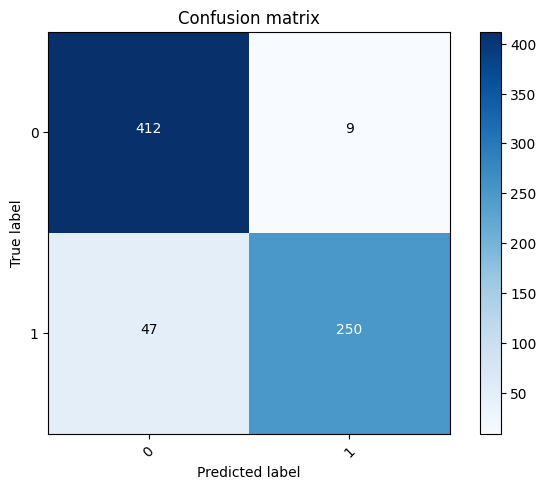

In [ ]:
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']
real_image_path = '/content/drive/MyDrive/casia/CASIA2/Au/Au_ani_00009.jpg'
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

fake_image_path = '/content/drive/MyDrive/casia/CASIA2/Tp/Tp_D_CNN_M_N_ind00091_ind00091_10647.jpg'
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 477ms/step
Class: real Confidence: 98.68
1/1 [==============================] - 0s 33ms/step
Class: fake Confidence: 100.00


In [ ]:
fake_image = os.listdir('/content/drive/MyDrive/casia/CASIA2/Tp')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('/content/drive/MyDrive/casia/CASIA2/Tp', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1

1/1 [==============================] - 0s 20ms/step


In [ ]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2089, Correct: 2076, Acc: 99.3776926759215


In [ ]:
real_image = os.listdir('/content/drive/MyDrive/casia/CASIA2/Au')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('/content/drive/MyDrive/casia/CASIA2/Au', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


In [ ]:
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')

Total: 7465, Correct: 6710, Acc: 89.8861352980576


In [ ]:
correct += correct_r
total += total_r
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 9554, Correct: 8786, Acc: 91.96148210173749


In [ ]:
TP = confusion_mtx[1, 1]
TN = confusion_mtx[0, 0]
FP = confusion_mtx[0, 1]
FN = confusion_mtx[1, 0]

# Calculate precision
#precision = TP / float(TP + FP)

# Calculate recall
#recall = TP / float(TP + FN)

# Calculate F1 score
#f1_score = 2 * (precision * recall) / (precision + recall)

#print("Precision:", precision)
#print("Recall:", recall)
#print("F1 Score:", f1_score)
# Calculate accuracy

accuracy = (TP + TN) / float(TP + TN + FP + FN)
print("Accuracy:", accuracy)

# Calculate true positive rate (Sensitivity or Recall)
tpr = TP / float(TP + FN)
print("True Positive Rate (Recall):", tpr)

# Calculate true negative rate (Specificity)
tnr = TN / float(TN + FP)
print("True Negative Rate (Specificity):", tnr)

# Calculate false positive rate
fpr = FP / float(FP + TN)
print("False Positive Rate:", fpr)

# Calculate false negative rate
fnr = FN / float(FN + TP)
print("False Negative Rate:", fnr)

# Calculate precision
precision = TP / float(TP + FP)
print("Precision:", precision)

# Calculate recall
recall = TP / float(TP + FN)
print("Recall:", recall)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)

Accuracy: 0.9220055710306406
True Positive Rate (Recall): 0.8417508417508418
True Negative Rate (Specificity): 0.9786223277909739
False Positive Rate: 0.021377672209026127
False Negative Rate: 0.15824915824915825
Precision: 0.9652509652509652
Recall: 0.8417508417508418
F1 Score: 0.8992805755395683


In [ ]:
import pandas as pd
from tabulate import tabulate

# Define the data
data = {
    "Model": ["CNN Model", "VGG16", "ResNet101"],
    "Accuracy (%)": [accuracy, vgg_accuracy, res_accuracy],
    "Precision (%)": [precision, vgg_precision, res_precision],
    "Recall (%)": [recall, vgg_recall, res_recall],
    "F1 Score (%)": [f1_score, vgg_f1_score, res_f1_score],
    "TPR (%)": [tpr, vgg_tpr, res_tpr],
    "TNR (%)": [tnr, vgg_tnr, res_tnr],
    "FPR (%)": [fpr, vgg_fpr, res_fpr],
    "FNR (%)": [fnr, vgg_fnr, res_fnr]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Format percentage columns
percentage_columns = ["Accuracy (%)", "Precision (%)", "Recall (%)", "F1 Score (%)", "TPR (%)", "TNR (%)", "FPR (%)", "FNR (%)"]
df[percentage_columns] = df[percentage_columns].apply(lambda x: x.map(lambda y: f"{y:.2%}"))

# Display the DataFrame as a visually pleasing table
table = tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False)
print(table)

╒═══════════╤════════════════╤═════════════════╤══════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│ Model     │ Accuracy (%)   │ Precision (%)   │ Recall (%)   │ F1 Score (%)   │ TPR (%)   │ TNR (%)   │ FPR (%)   │ FNR (%)   │
╞═══════════╪════════════════╪═════════════════╪══════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ CNN Model │ 92.20%         │ 96.53%          │ 84.18%       │ 89.93%         │ 84.18%    │ 97.86%    │ 2.14%     │ 15.82%    │
├───────────┼────────────────┼─────────────────┼──────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ VGG16     │ 86.91%         │ 89.59%          │ 87.89%       │ 88.73%         │ 87.89%    │ 85.52%    │ 14.48%    │ 12.11%    │
├───────────┼────────────────┼─────────────────┼──────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ ResNet101 │ 65.88%         │ 98.15%          │ 17.85%       │ 30.20%         │ 17.85%    │ 99.7

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dummy data
accuracy_values = [accuracy * 100, vgg_accuracy * 100, res_accuracy * 100]
precision_values = [precision * 100, vgg_precision * 100, res_precision * 100]
recall_values = [recall * 100, vgg_recall * 100, res_recall * 100]

models = ["CNN", "VGG16", "ResNet101"]

# Set Seaborn style
sns.set_style("whitegrid")

# Create a bar graph for Accuracy using Seaborn color palette
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accuracy_values, palette='BuPu')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()

# Create a bar graph for Precision using Seaborn color palette
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=precision_values, palette='BuPu')
plt.title('Precision Comparison')
plt.ylabel('Precision (%)')
plt.ylim(0, 100)
plt.show()

# Create a bar graph for Recall using Seaborn color palette
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=recall_values, palette='BuPu')
plt.title('Recall Comparison')
plt.ylabel('Recall (%)')
plt.ylim(0, 100)
plt.show()


In [ ]:
loaded_model = load_model('model_casia_run1.h5')

In [ ]:
# Function to prepare the image for prediction
def prepare_image_for_prediction(image_path):
    # Load and prepare the image
    image = prepare_image(image_path)
    image = image.reshape(-1, 128, 128, 3)
    return image

# Function to make predictions on a single image
def predict_single_image(image_path, model):
    # Prepare the image for prediction
    image = prepare_image_for_prediction(image_path)
    # Make predictions
    y_pred = model.predict(image)
    y_pred_class = np.argmax(y_pred, axis=1)[0]
    confidence = np.amax(y_pred) * 100
    return class_names[y_pred_class], confidence

# Function to display the image with prediction
def display_image_with_prediction(image_path, model):
    # Load the image
    image = Image.open(image_path)
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    # Predict the class and confidence
    image_class, confidence = predict_single_image(image_path, model)
    print(f'Prediction: Class: {image_class}, Confidence: {confidence:.2f}%')

# Example usage:
fake_image_path = '/content/drive/MyDrive/casia/CASIA2/Tp/Tp_D_CND_S_N_txt00028_txt00006_10848.jpg'

# Display fake image with prediction
display_image_with_prediction(fake_image_path, model)